In [33]:
# rad1_multistep_periodic.py
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import splu

# -------------------- Config --------------------
SEED = 7
rng = np.random.default_rng(SEED)

# Linear RAD params (stable)
Du = 0.01
c  = 0.5
alpha = -1.0

# Nonlinear term (damping)
kappa = -1.0  # -kappa*u^2

# Grid / time
Nx = 100
Lx = 1.0
x_grid = np.linspace(0.0, Lx, Nx, endpoint=False)
dx = x_grid[1] - x_grid[0]

Ts      = 2e-2
T_steps = 21
N_traj  = 1000

# Multi-input control
n_u      = 8
MIN_HOLD, MAX_HOLD = 1, 4
U_AMP = 0.25

SAVE_PATH = "rad1_multistep_periodic.npz"

# -------------------- Build control basis B(x) (periodic cosines) --------------------
B = np.zeros((Nx, n_u))
for i in range(1, n_u + 1):
    B[:, i-1] = np.cos(2*np.pi*i*x_grid/Lx)
col_norms = np.sqrt(np.sum(B**2, axis=0) * dx)
B /= (col_norms + 1e-12)

# -------------------- Spatial operators (PERIODIC) --------------------
e = np.ones(Nx)

# Periodic Laplacian
L = sparse.diags([e, -2*e, e], offsets=[-1, 0, 1], shape=(Nx, Nx)).tolil()
L[0, -1] = 1.0
L[-1, 0] = 1.0
L = (L / dx**2).tocsr()

I = sparse.eye(Nx, format="csr")
Au = (I - Ts*Du*L).tocsr()
lu_u = splu(Au.tocsc())

# -------------------- Helpers --------------------
def make_prbs_matrix(T, n_u, amp, rng, min_hold=10, max_hold=40):
    U = np.empty((n_u, T))
    for i in range(n_u):
        seq = np.empty(T)
        t = 0
        while t < T:
            hold = int(rng.integers(min_hold, max_hold + 1))
            val = amp if rng.random() < 0.5 else -amp
            seq[t:t+hold] = val
            t += hold
        U[i] = seq[:T]
    return U

def smooth_random_periodic(x, Lx, K=16, decay=0.0, std=1.0, rng=np.random.default_rng(0)):
    """
    Periodic zero-mean IC ~ sum_k a_k cos(2πkx/Lx) + b_k sin(2πkx/Lx)
    """
    u = np.zeros_like(x)
    for k in range(1, K+1):
        scale = np.exp(-decay * k**2)
        ak = rng.standard_normal() * scale
        bk = rng.standard_normal() * scale
        u += ak * np.cos(2*np.pi*k*x/Lx) + bk * np.sin(2*np.pi*k*x/Lx)
    u -= u.mean()
    s = u.std()
    if s > 0:
        u *= (std / s)
    return u

def advective_flux_upwind_periodic(u, dx, c):
    """
    Periodic upwind derivative du/dx (first order).
    Uses backward diff if c>=0, forward diff if c<0.
    """
    if c >= 0.0:
        dudx = (u - np.roll(u, 1)) / dx      # backward
    else:
        dudx = (np.roll(u, -1) - u) / dx     # forward
    return -c * dudx

def rad1_step(u, a_vec):
    """One IMEX-Euler step for 1D RAD with multi-input control (periodic)."""
    adv  = advective_flux_upwind_periodic(u, dx, c)
    reac = alpha * u
    nl   = -(kappa * u**2)
    c_u  = B @ a_vec
    rhs  = u + Ts * (adv + reac + nl + c_u)
    u_next = lu_u.solve(rhs)
    return u_next

# -------------------- Dataset generation --------------------
def generate_dataset(N_traj, T_steps, Ts, rng):
    n = Nx
    Xs, Ys, Us = [], [], []
    for _ in range(N_traj):
        u = smooth_random_periodic(x_grid, Lx, K=16, decay=0.0, std=1.0, rng=rng)
        U_seq = make_prbs_matrix(T_steps, n_u, U_AMP, rng, MIN_HOLD, MAX_HOLD)
        X_traj = np.empty((n, T_steps))
        for k in range(T_steps):
            X_traj[:, k] = u
            u = rad1_step(u, U_seq[:, k])
        Xs.append(X_traj[:, :-1])
        Ys.append(X_traj[:, 1:])
        Us.append(U_seq[:, :-1])
    X = np.stack(Xs, axis=0)
    Y = np.stack(Ys, axis=0)
    U = np.stack(Us, axis=0)
    return X, Y, U

# -------------------- Main --------------------
if __name__ == "__main__":
    X, Y, U = generate_dataset(N_traj, T_steps, Ts, rng)
    np.savez_compressed(
        SAVE_PATH, X=X, Y=Y, U=U,
        Ts=Ts, Nx=Nx, Lx=Lx, dx=dx, n_u=n_u,
        Du=Du, c=c, alpha=alpha, kappa=kappa,
        B=B, B_desc="columns are cosine control shapes b_i(x) (L2-normalized, periodic)",
        N_traj=N_traj, T_steps=T_steps,
        meta=dict(description="1-species nonlinear RAD (IMEX FD) with multi-input control, PERIODIC BCs",
                  seed=SEED, N_traj=N_traj, T_steps=T_steps,
                  state_dim=Nx, input_dim=n_u)
    )
    print("Saved:", SAVE_PATH)
    print("Shapes: X", X.shape, "Y", Y.shape, "U", U.shape, "| B:", B.shape)


Saved: rad1_multistep_periodic.npz
Shapes: X (1000, 100, 20) Y (1000, 100, 20) U (1000, 8, 20) | B: (100, 8)


In [34]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------- loader (1 field only) --------------------
def load_rad1(npz_path="rad1_multistep_periodic.npz", traj_index=0, return_full_U=True):
    """
    Returns:
      u_mat : (Nx, T)   state
      U_seq : (m, T-1)  controls (if return_full_U) else (T-1,) first channel
      x, t, Ts, B, dx, data
    """
    data = np.load(npz_path, allow_pickle=True)
    X, Y, U = data["X"], data["Y"], data["U"]            # (N_traj, n, T-1), (N_traj, n_u, T-1)
    Ts = float(data["Ts"]); Nx = int(data["Nx"]); Lx = float(data["Lx"]); dx = float(data["dx"])
    n  = X.shape[1]; Tm1 = X.shape[2]
    assert n == Nx, f"Dataset is not 1-field: n={n}, Nx={Nx}"

    X_traj = X[traj_index]                                # (Nx, T-1)
    Y_traj = Y[traj_index]                                # (Nx, T-1)
    u_mat  = np.concatenate([X_traj, Y_traj[:, -1][:, None]], axis=1)  # (Nx, T)
    U_seq  = U[traj_index] if return_full_U else U[traj_index, 0]       # (m,T-1) or (T-1,)

    x = np.linspace(0.0, Lx, Nx, endpoint=False)
    t = np.arange(Tm1 + 1) * Ts
    B = data["B"]
    return u_mat, U_seq, x, t, Ts, B, dx, data


# -------------------- spacetime (1 field) --------------------
def plot_spacetime1(u_mat, x, t, center_zero=False, title="u(x,t)"):
    fig, ax = plt.subplots(1, 1, figsize=(5.6, 3.6), constrained_layout=True)
    if center_zero:
        vmax = np.nanmax(np.abs(u_mat)); vmin, vmax = -vmax, vmax
        im = ax.pcolormesh(t, x, u_mat, shading="auto", vmin=vmin, vmax=vmax)
    else:
        im = ax.pcolormesh(t, x, u_mat, shading="auto")
    ax.set_title(title); ax.set_xlabel("t"); ax.set_ylabel("x")
    fig.colorbar(im, ax=ax); plt.show()


# -------------------- means/norms + inputs (1 field) --------------------
def plot_means_norms1(u_mat, U_seq, t, show_inputs="norm", B=None, dx=None):
    """
    show_inputs: "none" | "norm" (||u(t)||2) | "fieldnorm" (||B u(t)||_L2)
    U_seq: (m,T-1) or (T-1,) if single channel
    """
    Nx, T = u_mat.shape
    mean_u = u_mat.mean(axis=0)
    nrm_u  = np.sqrt((u_mat*u_mat).mean(axis=0))  # ||·||2 / √Nx

    fig, axs = plt.subplots(2, 1, figsize=(8.0, 4.8), sharex=True, constrained_layout=True)
    axs[0].plot(t, mean_u, label="mean(u)")
    axs[0].set_ylabel("spatial mean"); axs[0].grid(True, alpha=0.3); axs[0].legend()

    axs[1].plot(t, nrm_u, label="‖u(·,t)‖₂/√Nₓ")
    if show_inputs != "none" and U_seq is not None:
        if np.ndim(U_seq) == 1:
            U2 = U_seq[None, :]              # (1, T-1)
        else:
            U2 = U_seq                        # (m, T-1)
        if show_inputs == "norm":
            axs[1].step(t[:-1], np.linalg.norm(U2, axis=0), where="post", label="‖u(t)‖₂", alpha=0.85)
        elif show_inputs == "fieldnorm":
            assert B is not None and dx is not None, "Need B, dx for fieldnorm."
            if U2.shape[0] == 1 and B.shape[1] > 1:
                # use first actuator column if only one channel passed
                Bu = B[:, [0]] * U2          # (Nx, T-1)
            else:
                if B.shape[1] != U2.shape[0]:
                    raise ValueError(f"B has {B.shape[1]} cols but U_seq has {U2.shape[0]} rows.")
                Bu = B @ U2                  # (Nx, T-1)
            Bu_L2 = np.sqrt(np.sum(Bu*Bu, axis=0) * dx)
            axs[1].step(t[:-1], Bu_L2, where="post", label="‖B u(t)‖_L2", alpha=0.85)
    axs[1].set_xlabel("t"); axs[1].set_ylabel("norm / input"); axs[1].grid(True, alpha=0.3); axs[1].legend()
    plt.show()


# -------------------- profiles (1 field) --------------------
def plot_profiles1(u_mat, x):
    fig, ax = plt.subplots(1, 1, figsize=(7.0, 3.2), constrained_layout=True)
    ax.plot(x, u_mat[:, 0],  "-",  lw=1.7, label="u(x,0)")
    ax.plot(x, u_mat[:, -1], "--", lw=1.7, label="u(x,T)")
    ax.set_xlabel("x"); ax.set_ylabel("value"); ax.set_title("Initial vs final")
    ax.grid(True, alpha=0.3); ax.legend(); plt.show()


In [35]:
import numpy as np
d1_op = lambda u: (u - np.roll(u, 1)) / dx if c >= 0 else (np.roll(u, -1) - u) / dx
L_op = lambda v: L @ v
rad_step = rad1_step
make_inputs = lambda T: make_prbs_matrix(T, n_u, U_AMP, rng, MIN_HOLD, MAX_HOLD)
u0 = smooth_random_periodic(x_grid, Lx, K=16, decay=0, std=1.0, rng=rng)

# ---------- L2 over space ----------
def l2_space(field, dx):
    """Discrete L2(Ω) norm: ||f||_L2 ≈ sqrt(Σ_j f_j^2 Δx)."""
    f = np.asarray(field, dtype=np.float64).ravel()
    return float(np.sqrt(np.sum(f*f) * dx))

# ---------- per-term magnitudes for RAD-1D (periodic) ----------
def term_sizes_rad1(u, a_vec, *, B, dx, Du, c, alpha, kappa, d1_op=None, L_op=None):
    """
    L2 magnitudes of each PDE term for 1D RAD with distributed input.
    PDE: y_t = Du*y_xx - c*y_x + alpha*y - kappa*y^2 + B@a
    Arguments marked * are keyword-only to make call-sites explicit.

    Parameters
    ----------
    u : (Nx,) array   current state
    a_vec : (m,)      current control vector
    B : (Nx,m)        actuator matrix (columns are b_i(x))
    dx : float        grid spacing
    Du, c, alpha, kappa : floats  PDE coefficients
    d1_op : callable  first-derivative operator, d1_op(u) -> y_x  (e.g., upwind)
    L_op  : callable  Laplacian operator,  L_op(u) -> y_xx        (or matrix @)

    Returns
    -------
    dict with L2 magnitudes per term and totals.
    """
    # Input field
    u_in = B @ a_vec                        # (Nx,)

    # Derivatives
    ux  = d1_op(u) if callable(d1_op) else None
    uxx = L_op(u)  if callable(L_op)  else None

    # Individual term fields (pointwise contributions on RHS)
    adv   = -c * ux                        if ux  is not None else 0.0
    diff  =  Du * uxx                      if uxx is not None else 0.0
    linr  =  alpha * u
    nl    = -kappa * (u**2)                # NOTE: κ>0 => damping; κ<0 => destabilizing

    # L2 magnitudes
    out = {
        "adv":   l2_space(adv,  dx) if ux  is not None else 0.0,
        "diff":  l2_space(diff, dx) if uxx is not None else 0.0,
        "linr":  l2_space(linr, dx),
        "nl":    l2_space(nl,   dx),
        "input": l2_space(u_in, dx),
    }

    # Totals
    rhs_no_input = (adv if ux is not None else 0.0) + (diff if uxx is not None else 0.0) + linr + nl
    rhs_with_in  = rhs_no_input + u_in
    out["rhs_no_input"]  = l2_space(rhs_no_input, dx)
    out["rhs_with_input"] = l2_space(rhs_with_in,  dx)
    return out

def pretty_print_sizes(sizes, prefix=""):
    order = ["adv","diff","linr","nl","input","rhs_no_input","rhs_with_input"]
    s = " | ".join(f"{k}: {sizes[k]:.3e}" for k in order)
    print((prefix + " " if prefix else "") + s)

# ---------- measure over a rollout using YOUR integrator ----------
def measure_term_sizes_over_rollout(T_meas, *, rng, rad_step, make_inputs, u0,
                                    B, dx, Du, c, alpha, kappa, d1_op, L_op):
    """
    Accumulate average per-term L2 magnitudes over T_meas steps.

    rad_step(u, a_vec) must advance by one step exactly as in your solver.
    make_inputs(T) must return (m, T) control sequence aligned with steps.
    """
    U_seq = make_inputs(T_meas)          # shape (m, T_meas)
    u = u0.copy()
    acc = None

    for k in range(T_meas):
        sizes = term_sizes_rad1(u, U_seq[:, k], B=B, dx=dx, Du=Du, c=c,
                                alpha=alpha, kappa=kappa, d1_op=d1_op, L_op=L_op)
        if acc is None:
            acc = {key: 0.0 for key in sizes}
        for key in sizes:
            acc[key] += sizes[key]
        u = rad_step(u, U_seq[:, k])     # one IMEX-Euler step (your rad1_step)

    avg = {k: v / T_meas for k, v in acc.items()}
    print(f"Per-term L2 averages over {T_meas} steps:")
    pretty_print_sizes(avg)
    return avg


avg_sizes = measure_term_sizes_over_rollout(
    T_meas=50,
    rng=rng,
    rad_step=rad1_step,
    make_inputs=make_inputs,
    u0=u0,
    B=B, dx=dx, Du=Du, c=c, alpha=alpha, kappa=kappa,
    d1_op=d1_op, L_op=L_op
)

Per-term L2 averages over 50 steps:
adv: 2.209e+00 | diff: 1.878e+00 | linr: 2.317e-01 | nl: 1.503e-01 | input: 7.071e-01 | rhs_no_input: 3.345e+00 | rhs_with_input: 3.368e+00


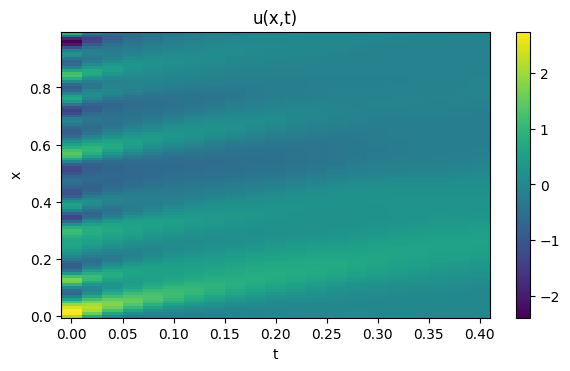

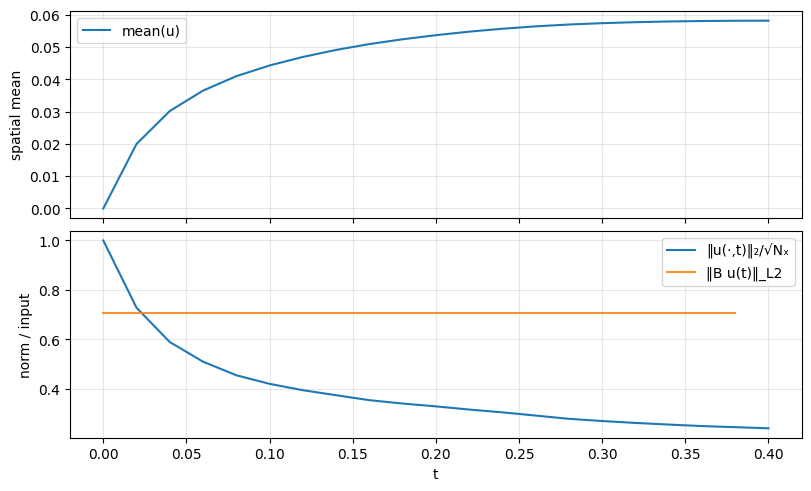

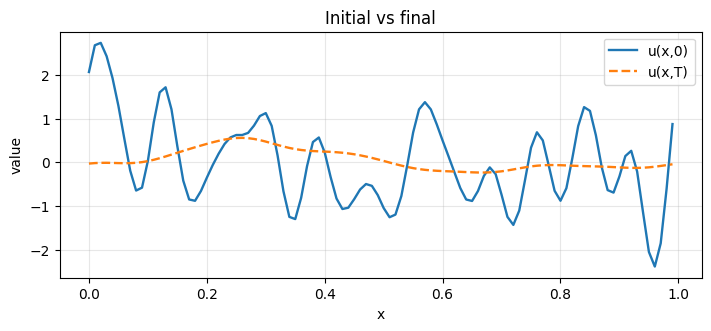

In [37]:

if __name__ == "__main__":
    # choose which trajectory to visualize
    TRAJ_IDX = 60
    u_mat, U_seq, x, t, Ts, B, dx, data = load_rad1("rad1_multistep_periodic.npz", traj_index=TRAJ_IDX)
    plot_spacetime1(u_mat, x, t)
    plot_means_norms1(u_mat, U_seq, t, show_inputs="fieldnorm", B=data["B"], dx=data["dx"])
    plot_profiles1(u_mat, x)

In [38]:
# ---- Fourier projections for 1 field ----
import numpy as np

# -------- helpers (periodic FD) --------
def d1_periodic(u, dx):
    # centered first derivative with periodic wrap
    return (np.roll(u, -1) - np.roll(u, 1)) / (2.0 * dx)

def d2_periodic(u, dx):
    # second derivative (Laplacian in 1D) with periodic wrap
    return (np.roll(u, -1) - 2.0*u + np.roll(u, 1)) / (dx**2)

# -------- Fourier projections (cos & sin) --------
def compute_observables(u, x_grid, Lx, dx, M=10, orthonormal=True):
    """
    Project u(x) onto first M cosine & sine modes on [0, Lx] with periodic BCs.
    Returns array of shape (2*M,): [<u, cos(1)>, ..., <u, cos(M)>, <u, sin(1)>, ..., <u, sin(M)>]
    If orthonormal=True, uses L2-orthonormal scaling on [0, Lx].
    """
    u = np.asarray(u, dtype=np.float64)
    obs = np.zeros(2*M, dtype=np.float64)

    # Orthonormal factors over [0, Lx] (exclude k=0)
    # ∥cos(kπx/Lx)∥^2 = ∥sin(kπx/Lx)∥^2 = Lx/2 for k>=1
    if orthonormal:
        norm_factor = np.sqrt(2.0 / Lx)
    else:
        norm_factor = 1.0

    # precompute trig table
    ks = np.arange(1, M+1, dtype=np.float64)
    ang = 2 * np.pi * np.outer(ks, x_grid / Lx)  # shape (M, Nx)
    cos_tbl = np.cos(ang) * norm_factor
    sin_tbl = np.sin(ang) * norm_factor

    # inner products via Riemann sum
    # first M are cos, next M are sin
    obs[:M]  = (cos_tbl @ u) * dx
    obs[M:]  = (sin_tbl @ u) * dx
    return obs

# -------- main psi builder --------
def make_psi_rad(x_grid, Lx, dx,
                 M=10,
                 include_bias=True,
                 include_fourier=True,
                 include_energy=True,
                 include_cubic_energy=False,
                 include_poly_moments=True,
                 include_diff_stats=True,
                 include_x=False):
    """
    Build a modest, RAD-friendly observable map ψ(u):
      - bias (1)
      - Fourier projections (2M): cos/sin k=1..M (orthonormalized)
      - energy terms: mean(u^2)
      - polynomial moments: mean(u), mean(u^3)   (low-order only)
      - differential stats: mean( (u_x)^2 ), mean( (u_xx)^2 )
      - (optional) raw field u (Nx)   [use sparingly]
    Notes:
      * Periodic BCs assumed for derivatives & Fourier.
      * Keep flags on default for a compact feature vector.
    """
    x_grid = np.asarray(x_grid, dtype=np.float64)
    Nx = x_grid.size

    def psi(u):
        u = np.asarray(u, dtype=np.float64).ravel()
        parts = []

        if include_bias:
            parts.append(np.array([1.0], dtype=np.float64))

        if include_fourier:
            parts.append(compute_observables(u, x_grid, Lx, dx, M=M, orthonormal=True))

        if include_energy:
            # ∫ u^2 dx (or mean) — we use mean to keep scale consistent across grids
            parts.append(u*u)
        if include_cubic_energy:
            parts.append(u**3)

        if include_poly_moments:
            # low-order only: mean(u), mean(u^3)
            parts.append(np.array([np.mean(u), np.mean(u**3)], dtype=np.float64))

        if include_diff_stats:
            ux  = d1_periodic(u, dx)
            uxx = d2_periodic(u, dx)
            # RAD-relevant smoothness/curvature measures
            parts.append(np.array([np.mean(ux*ux), np.mean(uxx*uxx)], dtype=np.float64))

        if include_x:
            # raw field — high-dimensional; leave off unless you really need it
            parts.append(u.copy())

        return np.concatenate(parts).astype(np.float64)
    



    return psi




def build_initial_blocks(X, U, Y, H, psi=lambda x: x):
    """
    Generic version: psi is any callable that maps x -> lifted features.
    Returns Psi0, U0, Y0, and inferred dimensions.
    """
    N_traj, n, Tm1 = X.shape
    m = U.shape[1]
    assert H <= Tm1, "H must be <= T_steps-1"

    # infer p from first sample
    psi0 = psi(X[0, :, 0])
    psi0 = np.asarray(psi0).ravel()
    p = psi0.size

    Psi0 = np.empty((N_traj, p))
    U0   = np.empty((N_traj, H * m))
    Y0   = np.empty((N_traj, H * n))

    for i in range(N_traj):
        x0 = X[i, :, 0]
        Psi0[i] = np.asarray(psi(x0)).ravel()
        U0[i]   = U[i, :, :H].ravel()
        Y0[i]   = Y[i, :, :H].ravel()

    return Psi0, U0, Y0, p, n, m

Shapes: Psi0 (1000, 303) U0 (1000, 160) Y0 (1000, 2000)
[[ 1.00000000e+00  8.46819936e+00  6.94713941e+00 ...  2.08571240e+00
   4.58245499e-01 -1.62144809e+00]
 [ 1.00000000e+00  1.02311032e-01  3.16037119e-01 ...  2.10889700e+00
   1.43735302e+00  4.40972787e-01]
 [ 1.00000000e+00  3.81885996e-01  3.74611622e-01 ... -1.37760842e+00
  -8.41426602e-01 -3.54007945e-04]
 ...
 [ 1.00000000e+00  2.63232286e+00  3.17819270e+00 ... -1.49897345e+00
  -4.58146789e-01  7.78061896e-01]
 [ 1.00000000e+00  2.49351817e-01  4.72711696e-03 ...  1.01993123e-01
   5.79449218e-01  7.40146631e-01]
 [ 1.00000000e+00  4.22491343e-03  2.24890100e-02 ...  1.46030514e+00
   1.64213572e+00  9.31776868e-01]]
Cond(Psi0): 5.3189277066503206e+17
Cond(U0): 5.96432201529499
Singular values of Psi0: [3.20704799e+02 2.30409517e+02 2.24061784e+02 2.18783782e+02
 2.14549795e+02 2.13640524e+02 2.11334640e+02 2.07943045e+02
 2.06921905e+02 2.05503895e+02 2.03167339e+02 2.00763126e+02
 2.00257805e+02 1.96792593e+02 1.94688

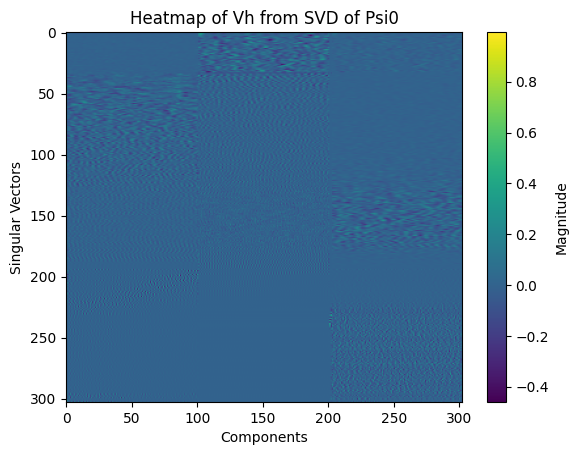

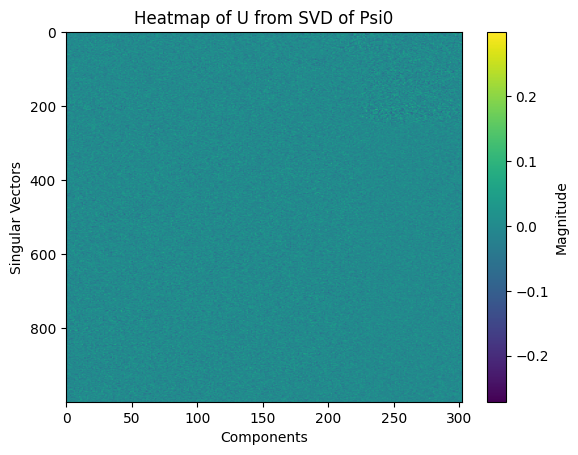

In [43]:
# ---- load or create your data as numpy arrays (columns = samples) ----
# X: (n, N), Y: (n, N), U: (m, N), THETA: (N,)
# For demo, we'll create placeholders; replace these with your data.
# ---------- build features (ψ) ----------
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import splu
if __name__ == "__main__":
    data = np.load("rad1_multistep_periodic.npz", allow_pickle=True)
    X = data["X"]      # (N_traj, n, T-1)
    U = data["U"]      # (N_traj, m, T-1)
    Y = data["Y"]      # (N_traj, n, T-1)
    Nx = int(data["Nx"]); Lx = float(data["Lx"]); n_u = int(data["n_u"])
    meta = {"dx": dx, "dt": float(data["Ts"])}

    # split by trajectories
    N_traj = X.shape[0]
    n_train = int(1.0*N_traj)
    Xtr, Utr , Ytr  = X[:n_train], U[:n_train], Y[:n_train]
    Xte, Ute , Yte = X[n_train:], U[n_train:], Y[n_train:]

    # choose horizon and lift hyperparams
    H = T_steps - 1
    lift_kwargs =  dict()

    # build initial-only blocks
    psi = make_psi_rad(x_grid, Lx, dx,
                       M=30,
                       include_bias=True,
                       include_fourier=False,
                       include_energy=True,
                       include_cubic_energy=True,
                       include_poly_moments=True,
                       include_diff_stats=False,
                       include_x=True)

    Psi0, U0, Y0, p, n, m = build_initial_blocks(Xtr, Utr, Ytr, H, psi=psi)
    print("Shapes: Psi0", Psi0.shape, "U0", U0.shape, "Y0", Y0.shape)
    #print condition numbers
    from numpy.linalg import cond
    print(Psi0)
    print("Cond(Psi0):", cond(Psi0))
    print("Cond(U0):", cond(U0))
    #check svd
    from numpy.linalg import svd
    U_svd, S_svd, Vh_svd = svd(Psi0, full_matrices=False)
    print("Singular values of Psi0:", S_svd)
    print("rank of Psi0:", np.sum(S_svd > 1e-3))
    #heatmap of Vh_svd
    import matplotlib.pyplot as plt
    plt.imshow(Vh_svd, aspect='auto', cmap='viridis')
    plt.colorbar(label='Magnitude')
    plt.title('Heatmap of Vh from SVD of Psi0')
    plt.xlabel('Components')
    plt.ylabel('Singular Vectors')
    plt.show()
    #heatmap of U_svd
    plt.imshow(U_svd, aspect='auto', cmap='viridis')
    plt.colorbar(label='Magnitude')
    plt.title('Heatmap of U from SVD of Psi0')
    plt.xlabel('Components')
    plt.ylabel('Singular Vectors')
    plt.show()

In [44]:
def edmdc(X, Y, U, psi, lam=0.0):
    """One-step EDMDc (Koopman with control)
    X, Y: (N × n_x)
    U: (N × m)
    psi: lifting function ψ(x) → ℝ^p
    lam: ridge regularization
    Returns A, B such that ψ(x_{t+1}) ≈ A ψ(x_t) + B u_t
    """
    Psi_X = psi(X).T
    print(Psi_X.shape)
    Psi_Y = psi(Y).T
    print(U.shape)
    H = np.hstack([Psi_X, U.T])
    G = H.T @ H + lam * np.eye(H.shape[1])
    print(np.linalg.cond(G))
    AB = np.linalg.solve(G, H.T @ Psi_Y)
    p = Psi_X.shape[1]
    A = AB[:p, :]
    B = AB[p:, :]
    return A, B

# Example usage of edmdc

A, B = edmdc(
        X=Xtr[:,:,0].reshape(-1, Nx).T,
        Y=Ytr[:,:,0].reshape(-1, Nx).T,
        U=Utr[:,:,0].reshape(-1, n_u).T,
        psi=lambda x: np.array([psi(xi) for xi in x.T]).T,
        lam=1e-8)
print("Learned A shape:", A.shape)
print("Learned B shape:", B.shape)
print("SVD of A: " , np.linalg.svd(A, full_matrices=False)[1])
print("Condition number of A:", np.linalg.cond(A))
print("Condition number of B:", np.linalg.cond(B))


(1000, 303)
(8, 1000)
10306383298068.48
Learned A shape: (303, 303)
Learned B shape: (8, 303)
SVD of A:  [1.39223906e+00 1.23194864e+00 1.10036589e+00 1.08394022e+00
 1.05944692e+00 1.02614009e+00 9.92529762e-01 9.86013417e-01
 9.58387136e-01 9.33807189e-01 8.73859500e-01 8.67321841e-01
 8.41799549e-01 8.22555770e-01 8.04705704e-01 7.95323722e-01
 7.47142166e-01 7.35492651e-01 7.25259404e-01 7.15923445e-01
 6.98911216e-01 6.96615152e-01 6.69451291e-01 6.67142734e-01
 6.61079503e-01 6.57478989e-01 6.43074923e-01 6.31141695e-01
 6.18841724e-01 6.08564209e-01 6.03400357e-01 5.92515146e-01
 5.88095493e-01 5.83880683e-01 5.75887268e-01 5.66468473e-01
 5.60146406e-01 5.53057478e-01 5.47541494e-01 5.37355066e-01
 5.33373771e-01 5.28954149e-01 5.21394079e-01 5.18211708e-01
 5.10942145e-01 5.07431077e-01 5.05402475e-01 5.03048574e-01
 4.98872305e-01 4.90261402e-01 4.85244597e-01 4.80904008e-01
 4.74433696e-01 4.68804292e-01 4.65514088e-01 4.61707940e-01
 4.49151528e-01 4.46267532e-01 4.42710210

In [45]:
def open_loop_rollout_edmdc_decoded(A, B, psi, x0, U_seq):
    """
    ψ_{t+1} = ψ_t A + u_t B, then decode ψ_{t+1} → x_{t+1} via decode_legendre2d
    x0: (1, n_x), U_seq: (H, m)
    returns X_pred: (H, n_x)
    """
    x = x0.copy()
    traj = []
    for k in range(U_seq.shape[0]):
        psi_x   = psi(x)                           # (1, p) numpy
        psi_nxt = psi_x @ A + U_seq[k:k+1] @ B  # (1, p) numpy
        #decode , last few entries are state
        x = psi_nxt[:, -Nx:]  # assuming last Nx entries are the state
        traj.append(x.squeeze())
    return np.vstack(traj)


def edmdc_mse_timewise_decoded(A, B, psi, X, Y, U, N_max = 100):
    Ntraj, n_x, H = X.shape
    Y_pred_all = np.zeros_like(Y[0:min(Ntraj,N_max)])
    for i in range(min(Ntraj,N_max)):
        x0    = X[i, :, 0:1].T        # (1, n_x)
        U_seq = U[i].T                # (H, m)
        Y_pred = open_loop_rollout_edmdc_decoded(A, B, psi, x0, U_seq)
        Y_pred_all[i] = Y_pred.T
    err = (Y[0:min(Ntraj,N_max)]  - Y_pred_all)**2
    return err.mean(axis=(0, 1))

# usage
mse_t_edmdc  = edmdc_mse_timewise_decoded(A, B, psi, X, Y, U)
print("Per-step MSE:", mse_t_edmdc)



Per-step MSE: [2.64914791e-23 3.80509049e-04 7.76026390e-04 1.08197015e-03
 1.32960140e-03 1.53590341e-03 1.71024811e-03 1.85826703e-03
 1.98419039e-03 2.09095796e-03 2.18079043e-03 2.25621907e-03
 2.31873207e-03 2.36988110e-03 2.41107540e-03 2.44286979e-03
 2.46573434e-03 2.48058390e-03 2.48859225e-03 2.49095868e-03]


In [46]:
#export mse_t_edmdc to npz file
np.savez_compressed("rad_edmdc_mse.npz", mse_t_edmdc = mse_t_edmdc)